In [1]:
import numpy as np

from Chempy.parameter import ModelParameters
from Chempy.cem_function import single_timestep_chempy

import sbi.utils as utils
from sbi.inference.base import infer
from sbi.analysis import pairplot

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t
import pickle


/Users/bguenes/miniconda3/envs/master_chempy_multi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ----- Set-up priors -----
a = ModelParameters()
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

In [12]:
def simulator_chempy(sample):
    out = single_timestep_chempy((sample.numpy().tolist(),a))
    if out[0].any() == np.inf or out[0].any() == -np.inf:
        return simulator_chempy(sample)
    else:
        return out[0]

In [13]:
# ----- sbi setup -----
num_sim = 100000
method = 'SNPE' #SNPE or SNLE or SNRE

start = t.time()
posterior = infer(
    simulator_chempy,
    combined_priors,
    method=method,
    num_simulations=num_sim)

print(f'Time taken to train the posterior with {num_sim} samples: {round(t.time() - start, 4)}s')



Running 100000 simulations.:   6%|▋         | 6281/100000 [04:44<1:10:41, 22.10it/s]

2 N
element N became negative. returning -inf


TypeError: 'float' object is not subscriptable

In [ ]:
with open("data/posterior_SNPE_chempy.pickle", "wb") as f:
    pickle.dump(posterior, f)

# Approach 2

In [9]:
import numpy as np
import time as t
import pickle

from sbi.inference import SNPE
import sbi.utils as utils

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

from Chempy.parameter import ModelParameters

In [15]:
# ------ Load & prepare the data ------

# --- Load in training data ---
path_training = '../ChempyMulti/tutorial_data/TNG_Training_Data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = '../ChempyMulti/tutorial_data/TNG_Test_Data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)

"""
# --- Normalize the data ---
x_mean, x_std = train_x.mean(axis=0), train_x.std(axis=0)
y_mean, y_std = train_y.mean(axis=0), train_y.std(axis=0)


def normalize_data(x, y, x_mean=x_mean, x_std=x_std, y_mean=y_mean, y_std=y_std):
    x = (x - x_mean) / x_std
    y = (y - y_mean) / y_std

    return x, y


train_x, train_y = normalize_data(train_x, train_y)
val_x, val_y     = normalize_data(val_x, val_y)
"""

train_x = torch.tensor(train_x).float()
train_y = torch.tensor(train_y).float()
val_x = torch.tensor(val_x).float()
val_y = torch.tensor(val_y).float()

'\n# --- Normalize the data ---\nx_mean, x_std = train_x.mean(axis=0), train_x.std(axis=0)\ny_mean, y_std = train_y.mean(axis=0), train_y.std(axis=0)\n\n\ndef normalize_data(x, y, x_mean=x_mean, x_std=x_std, y_mean=y_mean, y_std=y_std):\n    x = (x - x_mean) / x_std\n    y = (y - y_mean) / y_std\n\n    return x, y\n\n\ntrain_x, train_y = normalize_data(train_x, train_y)\nval_x, val_y     = normalize_data(val_x, val_y)\n'

In [10]:
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

In [18]:
inference = SNPE(prior=combined_priors)

In [19]:
start = t.time()
_ = inference.append_simulations(train_x, train_y).train()
posterior = inference.build_posterior()
print(f'Time taken to train the posterior with {len(train_y)} samples: {round(t.time() - start, 4)}s')

 Neural network successfully converged after 121 epochs.Time taken to train the posterior with 458472 samples: 3415.5876s


In [20]:
with open("data/posterior_SNPE_chempy.pickle", "wb") as f:
    pickle.dump(posterior, f)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:01<00:00, 7238.48it/s]


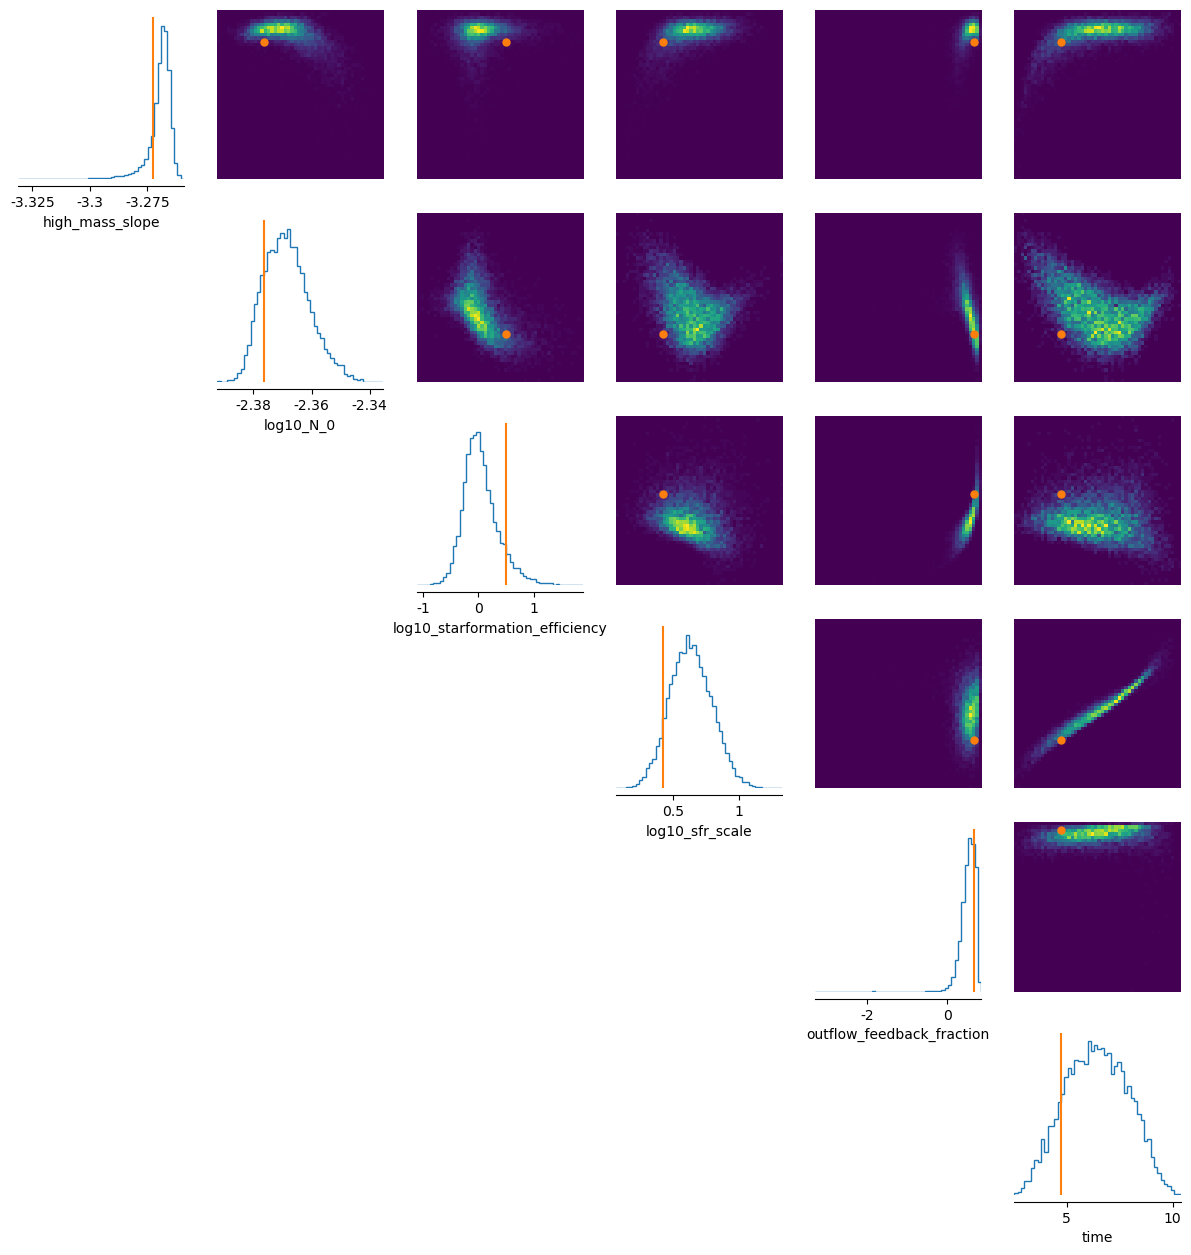

In [23]:
from sbi.analysis import pairplot

index = 1000
x = val_x[index]
y = val_y[index]

posterior_samples = posterior.sample((10000,), x=y)
_ = pairplot(posterior_samples, figsize=(15, 15), points=x, labels=labels)
